https://machinelearningmastery.com/building-a-regression-model-in-pytorch/

In [13]:
# check pytorch version
import torch
print(torch.__version__)

2.2.2+cpu


如何从 scikit-learn 加载数据并使其适应 PyTorch 模型
如何使用 PyTorch 创建回归问题的神经网络
如何通过数据准备技术提高模型性能

### 数据集描述
您将在本教程中使用的数据集是加州住房数据集。

这是一个描述加利福尼亚州地区房屋中位值的数据集。每个数据样本都是一个人口普查区块组。目标变量是 1990 年房屋价值中位数（100,000 美元），有 8 个输入特征，每个特征都描述了有关房屋的一些信息。他们是，即

MedInc：街区组收入中位数
HouseAge：街区组中的房屋年龄中位数
AveRooms：每户平均房间数
AveBedrms：每户平均卧室数
人口：街区组人口
AveOccup：家庭成员的平均数量
纬度：块组质心纬度
经度：块组质心经度

In [2]:
from sklearn.datasets import fetch_california_housing
 
data = fetch_california_housing()
print(data.feature_names)
 
X, y = data.data, data.target

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [12]:
print(X.shape, y.shape)

(20640, 8) (20640,)


### 构建模型并训练
这是一个回归问题。与分类问题不同，输出变量是连续值。对于神经网络，您通常在输出层使用线性激活（即无激活），这样输出范围理论上可以是从负无穷到正无穷的任何值。

同样对于回归问题，您永远不应该期望模型能够完美地预测值。因此，您应该关心预测与实际值的接近程度。为此可以使用的损失指标是均方误差 (MSE) 或平均绝对误差 (MAE)。但您可能还对均方根误差 (RMSE) 感兴趣，因为它是与输出变量具有相同单位的度量。

让我们尝试一下神经网络的传统设计，即金字塔结构。金字塔结构是随着网络前进到输出，每层神经元的数量逐渐减少。输入特征的数量是固定的，但是您在第一个隐藏层上设置了大量神经元，并逐渐减少后续层中的数量。由于此数据集中只有一个目标，因此最后一层应仅输出一个值。

In [4]:
!pip install torch

Looking in indexes: http://mirrors.aliyun.com/pypi/simple/
     ---------------------------------------- 0.0/198.6 MB ? eta -:--:--
     ---------------------------------------- 0.1/198.6 MB 3.5 MB/s eta 0:00:57
     ---------------------------------------- 0.3/198.6 MB 3.4 MB/s eta 0:00:59
     ---------------------------------------- 0.5/198.6 MB 3.8 MB/s eta 0:00:53
     ---------------------------------------- 0.6/198.6 MB 3.7 MB/s eta 0:00:54
     ---------------------------------------- 0.8/198.6 MB 3.6 MB/s eta 0:00:56
     ---------------------------------------- 0.9/198.6 MB 3.4 MB/s eta 0:00:58
     ---------------------------------------- 1.1/198.6 MB 3.4 MB/s eta 0:00:59
     ---------------------------------------- 1.2/198.6 MB 3.4 MB/s eta 0:00:58
     ---------------------------------------- 1.3/198.6 MB 3.2 MB/s eta 0:01:02
     ---------------------------------------- 1.5/198.6 MB 3.3 MB/s eta 0:01:01
     ---------------------------------------- 1.7/198.6 MB 3.3 MB/s 

In [5]:
import torch.nn as nn
 
# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

要训​​练该网络，您需要定义损失函数。 MSE是一个合理的选择。您还需要一个优化器，例如 Adam。



In [6]:
import torch.nn as nn
import torch.optim as optim

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

要训​​练此模型，您可以使用常用的训练循环。为了获得评估分数以便您确信模型有效，您需要将数据分为训练集和测试集。您可能还想通过跟踪测试集 MSE 来避免过度拟合。以下是训练-测试分割的训练循环：

In [7]:
import copy
import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split
 
# train-test split of the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
 
# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

在训练循环中，tqdm用于设置进度条，并在每个迭代步骤中计算并报告 MSE。通过将上面的tqdm参数设置disable为 ，您可以看到 MSE 如何变化False。

请注意，在训练循环中，每个 epoch 都会使用训练集运行几次前向和后向步骤来优化模型权重，并且在 epoch 结束时，使用测试集对模型进行评估。列表中记住的是测试集中的 MSE history。它也是评估模型的指标，最好的模型存储在变量 中best_weights。

运行此命令后，您将恢复最佳模型并将最佳 MSE 存储在变量 中best_mse。请注意，均方误差是预测值与实际值之差的平方平均值。它的平方根RMSE可以看作是平均差，在数值上更有用。

在下面，您可以显示 MSE 和 RMSE，并绘制 MSE 的历史。它应该随着时代的推移而减少。

MSE: 0.54
RMSE: 0.74


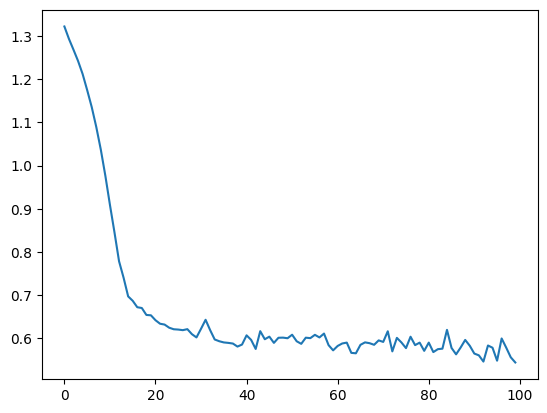

In [9]:
from matplotlib import pyplot as plt
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

https://machinelearningmastery.com/deep-learning-with-pytorch-9-day-mini-course/